# Bulgaria Employment Trends

[Go to main page](./../Bulgaria_Employment_Trends.ipynb)




## Salary Transparency




### Introduction

- Objective: To illustrate the ratio of job offer ads that have public salary announced as a part of the total offer count. 

To illustrate the data a percent stacked area graph is used. In this type of chart the value of each group is normalized at each time stamp.

### Methodology

Notes:
- Data is aggregated on weeks or months.
- 

### Prototyping

Using `matplotlib` to rapidly create an example graph.

In [21]:
import psycopg2
import pandas as pd
import matplotlib

%matplotlib notebook
%matplotlib inline

First we need to fetch the data from the database. We have a predefined query that will return the counts we need. We also drop the first and last week from the result since they contain partial data for the relevant periods.

In [22]:
conn = psycopg2.connect("dbname=jobsbg")
query = 'SELECT * FROM v_count_weekly_published_vs_unpublished_salary'

data_df = pd.read_sql_query(query, conn, index_col='week_ts')
data_df = data_df[1:-1]  # first and last week are incomplete so we drop them.
data_df.index = pd.to_datetime(data_df.index)  # convert the DataFrame index to DatetimeIndex object
data_df.head(1)

,published_salary,unpublished_salary
week_ts,,
2017-10-02,2076,7191


Then the counts are converted to percentages that represent a part of the whole. When stacked together the parts will add up to 100%.

In [23]:
publ_salary_ratio = data_df.apply(lambda row: row.published_salary / (row.published_salary + row.unpublished_salary) * 100, axis=1)
unpubl_salary_ratio = data_df.apply(lambda row: row.unpublished_salary / (row.published_salary + row.unpublished_salary) * 100, axis=1)

data_df = data_df.assign(publ_salary_ratio=publ_salary_ratio.values)
data_df = data_df.assign(unpubl_salary_ratio=unpubl_salary_ratio.values)
data_df.head(1)

,published_salary,unpublished_salary,publ_salary_ratio,unpubl_salary_ratio
week_ts,,,,
2017-10-02,2076,7191,22.402072,77.597928


A prototype chart view using the Pandas' `DataFrame.plot()` method can quickly show if the data is ready for plotting.

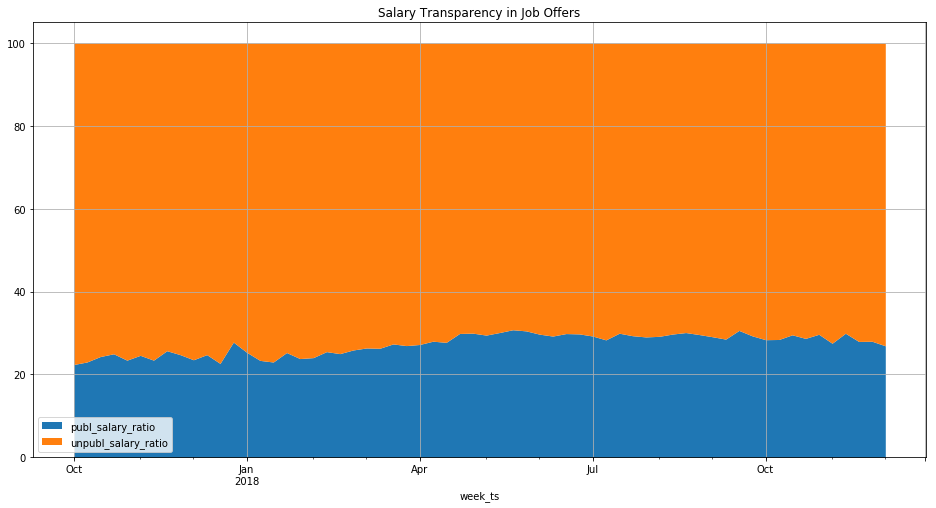

In [24]:
cols_to_plot = ['publ_salary_ratio', 'unpubl_salary_ratio']
data_df.plot(
    title='Salary Transparency in Job Offers',
    y=cols_to_plot,
    kind='area',
    grid=True,
    linewidth=0,
    figsize=(16,8)
)

This seems to be a good place to move on to Plotly.

### Implementing the Chart in Plotly





In [25]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True) # run at the start of every ipython notebook to use plotly.offline

Constructing the area traces for both possible values. They represent the data for the Plotly plot. Drawing directly as a line plot.

In [26]:
trace_publ = dict(
    x = data_df.index,
    y = data_df.publ_salary_ratio,
    text = data_df.published_salary,
    hoverinfo = 'text', 
    mode = 'lines',
    fillcolor = ('rgba(205, 12, 24, 0.3)'),
    line = dict(width = 2, color = ('rgba(205, 12, 24, 0.6)')),
    stackgroup = 'one',
    name = 'Published Salary',
)

trace_unpubl = dict(
    x = data_df.index,
    y = data_df.unpubl_salary_ratio,
    text = data_df.unpublished_salary,
    hoverinfo = 'text', 
    mode = 'lines',
    fillcolor = ('rgba(22, 96, 167, 0.3)'),
    line = dict(width = 0, color = ('rgba(22, 96, 167, 0.6)')),
    stackgroup = 'one',
    name = 'Unpublished Salary'
)

data = [trace_publ, trace_unpubl]

Preparing the layout for the Plotly plot. 

In [27]:
layout = go.Layout(
    title = 'Salary Transparency in Job Offer Ads',
    width = 920,
    height = 600,
    margin = dict(pad = 2),
    legend = dict(orientation = 'h'),
    modebar = dict(orientation = 'h'),
    showlegend = True,
    paper_bgcolor = '#F8F8EC',
    plot_bgcolor = '#F8F8EC',
    dragmode = 'zoom',
    xaxis = dict(type='date', title = '', ticks = 'outside', tickmode = 'array', tickvals = data_df.index, ticktext = data_df.index, tickangle = 0, tickformat = 'w%W/%y', nticks=20), 
    yaxis = dict(type='linear',range=[0,100], dtick=20, ticksuffix='%', fixedrange = True),
)

In [28]:
fig = go.Figure(data = data, layout = layout)
plotly.offline.iplot(fig, filename = 'salary_transparency')
# Uncomment the line below to export an HTML version of the chart.
# plotly.offline.plot(fig, filename = 'salary_transparency_result.html')